# Improving Adaboost through hyperparameter tuning

In [1]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import pandas as pd
import numpy as np

In [2]:
np.random.seed(0)

In [3]:
df = pd.read_parquet("../data/df.parquet")

In [4]:
y = df["sale_price"]
df.drop(columns=['sale_price'], inplace=True)
X = df

X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.25)

Given that adaboost was the worst model, we want to find a way to improve it. To do this, we implemeneted hyperparameter tuning by performing a grid search. This way, we would find the best hyperparameters for the model.

In [5]:
ada_reg = AdaBoostRegressor()

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [100, 600, 1000],
    'learning_rate': [0.1, 0.5, 1, 3, 5],
    'loss': ['linear', 'square', 'exponential'],
}

# Perform grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(ada_reg, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)


Best hyperparameters: {'learning_rate': 3, 'loss': 'linear', 'n_estimators': 600}


In [6]:
best_ada_reg = grid_search.best_estimator_
test_score = best_ada_reg.score(X_test, y_test)
print("Test set score with best hyperparameters:", test_score)

Test set score with best hyperparameters: 0.9711232025116384


# Fitting the model

When fitting the model with the new hyperparameters, we can see an improvement in the perfomance in terms of the matrics below.

In [7]:
adab_regressor = AdaBoostRegressor(learning_rate=3, loss='linear', n_estimators=600)
adab_regressor = adab_regressor.fit(X_train, y_train)

MAE = []
MSE = []
R2 = []

n_iterations = 1000
for i in range(n_iterations):
    X_bs, y_bs = resample(X_train, y_train, replace=True)
    # make predictions
    y_hat = adab_regressor.predict(X_bs)
    # evaluate model
    mae = mean_absolute_error(y_bs, y_hat)
    mse = mean_squared_error(y_bs, y_hat)
    r2 = r2_score(y_bs, y_hat)
    MAE.append(mae)
    MSE.append(mse)
    R2.append(r2)

print('MAE: ' + str(np.mean(MAE)))
print('MSE: ' + str(np.mean(MSE)))
print('R2: ' + str(np.mean(R2)))

MAE: 39687.50443284242
MSE: 2254205261.4901004
R2: 0.9708487321297998


In [8]:
y_pred=adab_regressor.predict(X_test)

# Model Evaluation (Metrics)

In [9]:
mae = mean_absolute_error(y_test, y_pred)
mae

41148.60686569556

In [10]:
mse = mean_squared_error(y_test, y_pred)
mse

2566139585.617007

In [11]:
r2 = r2_score(y_test, y_pred)
r2

0.9713305105838572

# Graphs (Expected Value vs Actual Data)

In [12]:
import matplotlib.pyplot as plt

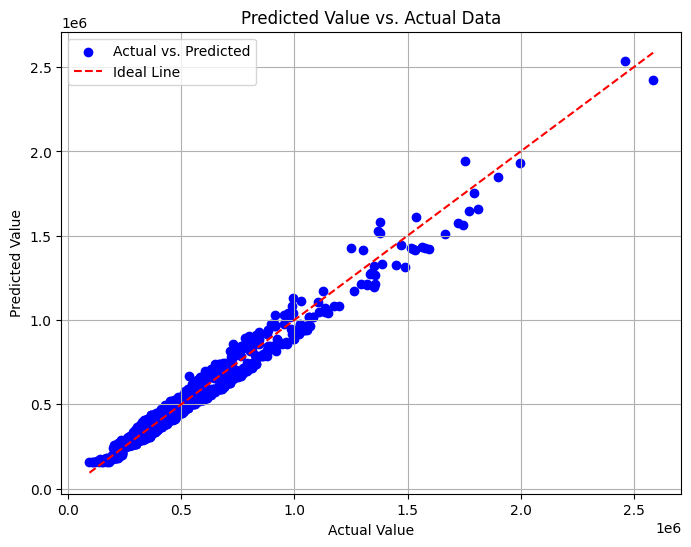

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Line')
plt.title('Predicted Value vs. Actual Data')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.legend()
plt.grid(True)
plt.show()

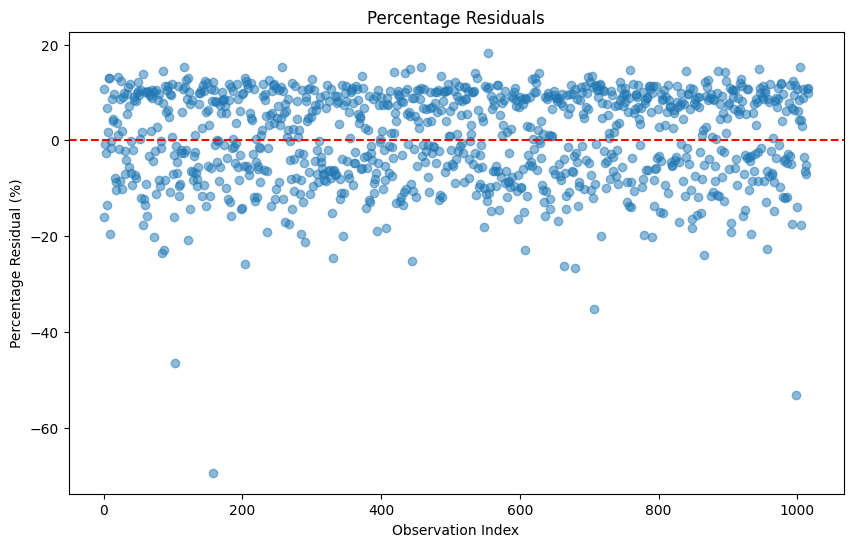

In [14]:
# Calculate percentage residuals: (Actual - Predicted) / Actual * 100
percentage_residuals = ((y_test - y_pred) / y_test) * 100

# Plotting percentage residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(percentage_residuals)), percentage_residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Percentage Residuals')
plt.xlabel('Observation Index')
plt.ylabel('Percentage Residual (%)')
plt.show()